Kelompok 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import json

IMG_PATH = "train"       
CSV_PATH = "train.csv"   
BATCH_SIZE = 8             
EPOCHS = 15            
LR = 1e-3     
OPTIM = "adam"          
Random_Seed = 42

In [23]:
class FoodDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.label_map = {
            "gado_gado": 0,
            "bakso": 1,
            "rendang": 2,
            "nasi_goreng": 3,
            "soto_ayam": 4
        }
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data.iloc[idx, 0])
        image = Image.open(img_name).convert("RGB")
        label = self.label_map[self.data.iloc[idx, 1]]
        if self.transform:
            image = self.transform(image)
        return image, label

# Transformasi data
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

# Dataset & split train/val
dataset = FoodDataset(csv_file=CSV_PATH, root_dir=IMG_PATH, transform=transform)
train_size = int(0.8 * len(dataset))
val_size   = len(dataset) - train_size
generator  = torch.Generator().manual_seed(Random_Seed)
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=generator)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [24]:
from plain34 import create_plain34
model = create_plain34(num_classes=5)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
model.to(device)

Device: cuda


Plain34(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage1): Sequential(
    (0): PlainBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): PlainBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   

In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

train_losses, val_losses = [], []
train_accs, val_accs = [], []

In [27]:
for epoch in range(EPOCHS):
    # Training
    model.train()
    correct, total, running_loss = 0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_acc  = 100. * correct / total
    
    # Validation
    model.eval()
    correct, total, running_loss = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    val_loss = running_loss / len(val_loader)
    val_acc  = 100. * correct / total
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    
    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
          f"Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

d:\Alat program\SupportSystem\Lib\site-packages\PIL\Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/15 | Train Loss: 1.5866 | Val Loss: 1.5764 | Train Acc: 28.56% | Val Acc: 34.68%
Epoch 2/15 | Train Loss: 1.6082 | Val Loss: 1.6300 | Train Acc: 23.70% | Val Acc: 24.32%
Epoch 3/15 | Train Loss: 1.5967 | Val Loss: 1.6011 | Train Acc: 25.62% | Val Acc: 34.23%
Epoch 4/15 | Train Loss: 1.4842 | Val Loss: 1.6009 | Train Acc: 31.49% | Val Acc: 29.28%
Epoch 5/15 | Train Loss: 1.4588 | Val Loss: 1.3484 | Train Acc: 36.79% | Val Acc: 43.69%
Epoch 6/15 | Train Loss: 1.3373 | Val Loss: 1.3167 | Train Acc: 45.71% | Val Acc: 46.40%
Epoch 7/15 | Train Loss: 1.2782 | Val Loss: 1.2797 | Train Acc: 47.86% | Val Acc: 41.89%
Epoch 8/15 | Train Loss: 1.2682 | Val Loss: 1.2217 | Train Acc: 48.19% | Val Acc: 57.66%
Epoch 9/15 | Train Loss: 1.2182 | Val Loss: 1.1187 | Train Acc: 51.47% | Val Acc: 52.70%
Epoch 10/15 | Train Loss: 1.2966 | Val Loss: 1.2403 | Train Acc: 46.84% | Val Acc: 54.95%
Epoch 11/15 | Train Loss: 1.2653 | Val Loss: 1.2239 | Train Acc: 49.32% | Val Acc: 52.70%
Epoch 12/15 | Train

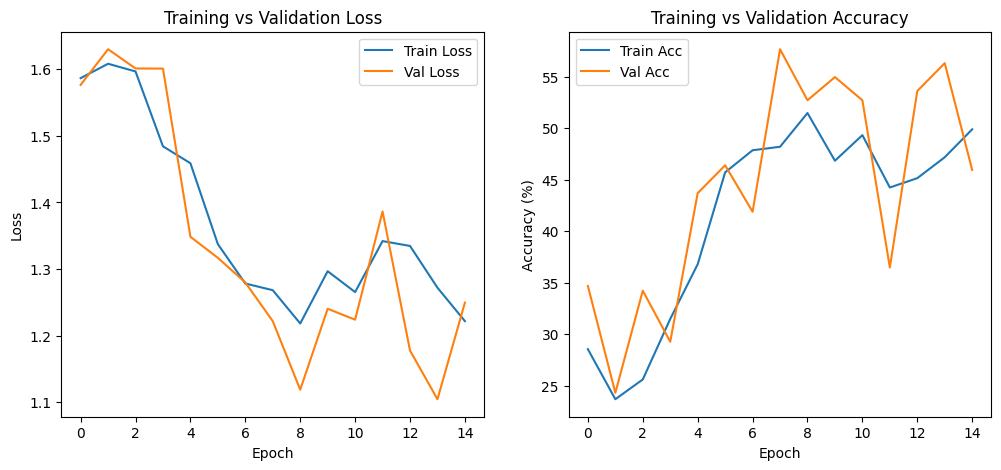

In [28]:
plt.figure(figsize=(12,5))

# Loss
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training vs Validation Accuracy')
plt.legend()

plt.show()


In [29]:
torch.save(model.state_dict(), "plain34_food5.pth")
print("Model disimpan ke plain34_food5.pth")

np.savez("plain34_history.npz",
         train_loss=np.array(train_losses),
         val_loss=np.array(val_losses),
         train_acc=np.array(train_accs),
         val_acc=np.array(val_accs),
         meta=np.array([json.dumps({
             "batch_size": BATCH_SIZE,
             "epochs": EPOCHS,
             "lr": LR,
             "optimizer": "adam",
             "split": "80/20",
             "seed": Random_Seed
         })], dtype=object))

print("Baseline performa Plain-34 disimpan ke plain34_history.npz")

Model disimpan ke plain34_food5.pth
Baseline performa Plain-34 disimpan ke plain34_history.npz
